In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('usd_curve_basic.csv')
times = data['t'].values
df0 = data['df'].values

#for i in range(len(times)):
#    print(times[i], "   ", df0[i])

class HullWhite():
    def __init__(self, a, sigma, timesteps, x0=0):
        self.a = a
        self.sigma = sigma
        self.timesteps = timesteps
        self.x0 = x0
        
    def hw_exp(self, x, t1, t2):
        return x * np.exp(-self.a * (t2 - t1))
    
    def hw_var(self, t1, t2):
        return self.sigma ** 2 * (1 - np.exp(-2 * self.a * (t2 - t1))) / (2 * self.a)

    def MC(self, sims):
        x = np.zeros((sims, self.timesteps))
        for i in range(sims):
            x[i,0] = self.x0
            for j in range(1, self.timesteps):
                Z1 = np.random.normal(0,1)
                x[i,j] = self.hw_exp(x[i,j-1], j-1, j) + Z1 * (self.hw_var(j-1,j) ** 0.5)
        return x     
    


In [121]:
class DiscountFactors():
    def __init__(self, a, sigma):
        self.a = a
        self.sigma = sigma
        
    def q_t(self, t, T):
         return (1 - np.exp(-self.a * (T - t))) / self.a

    def cov(self, t_i, t_j):
        return self.sigma ** 2 * (np.exp(-self.a * abs(t_j - t_i)) - np.exp(-self.a * (t_j + t_i))) / (2 * self.a)
 
    def hw_phi(self, q_val, cov_val):
        return sum(q * cov for q, cov in zip(q_values, cov_values))

    def hw_gamma(self, tn):
        return 0.5 * self.cov(tn, tn)

    def interpolated_df(self, t, time, df):
        return np.interp(t, time, df0)
    
    def df(self, t_n, T, x_tn, q_val, cov_val):
        B_tn = self.interpolated_df(t_n, times, df0)
        B_T = self.interpolated_df(T, times, df0)
        if t_n == 0:
            discount_factor = B_T / B_tn 
        else:
            phi = self.hw_phi(q_val, cov_val)
            gamma = self.hw_gamma(t_n)
            q_tn = self.q_t(t_n, T)
            discount_factor = (B_T / B_tn) * np.exp(-(x_tn + phi) * q_tn - gamma * (q_tn ** 2))
        return discount_factor
        

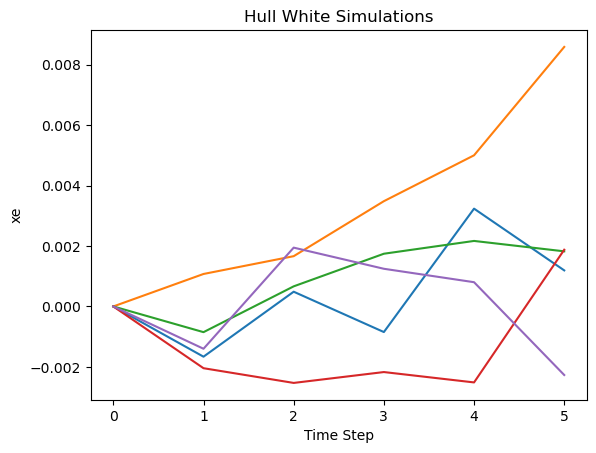

In [122]:
# Testing Hull White

a = 0.1
x0 = 0
sigma = 0.002

timesteps = 5

# MC Parameters
sims = 5
T = 5
dt = T / timesteps  
hw_timesteps = int(T / dt) + 1

hw = HullWhite(a, sigma, hw_timesteps, x0)
simulated_paths = hw.MC(sims)
hwdf = DiscountFactors(a, sigma)

#print (simulated_paths)
#print (hw_timesteps)
#print (dt)

for i in range(sims):
    plt.plot(simulated_paths[i])
plt.xlabel('Time Step')
plt.ylabel('xe')
plt.title('Hull White Simulations')
plt.show()

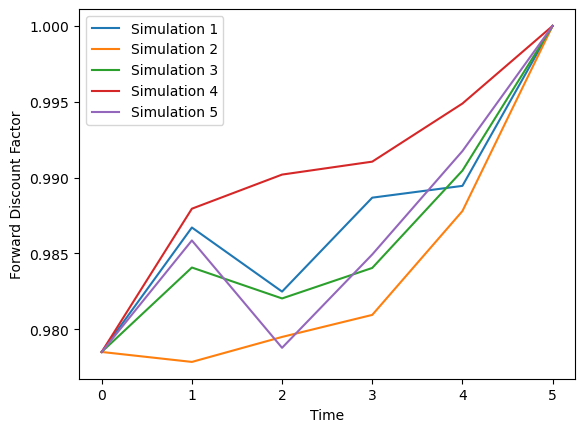

In [123]:
q_values = []
cov_values = []
for x in range(timesteps + 1):
    q_val1 = hwdf.q_t(x, x + 1)
    cov1 = hwdf.cov(x, timesteps + 1)
    q_values.append(q_val1)
    cov_values.append(cov1)

#result = sum(q * cov for q, cov in zip(q_values, cov_values))

#print(result)

for i in range(sims):
    x_tn_values = simulated_paths[i]

    for t_n in range(hw_timesteps):
        t = t_n * dt  
        T = T         
        q_val = hwdf.q_t(t, T)
        cov_val = hwdf.cov(t, T)
        discount_factor = hwdf.df(t, T, x_tn_values[t_n], q_val, cov_val)  
        
discount_factors = np.zeros((sims, hw_timesteps))        

       
for i in range(sims):
    x_tn_values = simulated_paths[i]
    for t_n in range(hw_timesteps):
        t = t_n * dt  
        T = T      
        q_val = hwdf.q_t(t, T)
        cov_val = hwdf.cov(t, T)
        discount_factors[i, t_n] = hwdf.df(t, T, x_tn_values[t_n], q_val, cov_val)

#print(discount_factors)        
       
for i in range(sims):
    plt.plot(np.arange(hw_timesteps) * dt, discount_factors[i], label=f'Simulation {i+1}')

plt.xlabel('Time')
plt.ylabel('Forward Discount Factor')
plt.legend()
plt.show()

In [131]:
# get all the discount factors to price a swap GETTING CLOSE HERE, X IS THE SAME - THINK I HAVE THIS!!!!

timesteps = 3

phi =  0
for i in range(timesteps):
    phi += hwdf.q_t(timesteps, T) * hwdf.cov(i, timesteps)

gamma = hwdf.hw_gamma(timesteps)


x_tn_array = np.array([simulated_paths[i] for i in range(sims)])

#print(x_tn_array)

df = np.zeros((sims, timesteps + 1, timesteps + 2))
fwd = np.zeros((sims, timesteps + 1, timesteps + 2))
swap_price = np.zeros((sims, timesteps))

dt = 1

#print(q_val)
#print(cov_val)


for i in range(sims):
    for j in range(timesteps + 1):
        for k in range(j, timesteps + 2):
            if (j == 0):
                df[i, 0, k] = df0[k]
            else:
                df[i, j, k] = hwdf.df(k, T, x_tn_array[i,j], q_val, cov_val)

        for k in range(j, timesteps + 1):
            fwd[i, j, k + 1] = - np.log(df[i, j, k + 1] / df[i, j, k]) / dt

print(df)

fwd = fwd[:, :, :-1]
#print(fwd)

[[[1.         0.997009   0.994587   0.99116    0.985859  ]
  [0.         0.98671015 0.98797463 0.99013966 0.9940773 ]
  [0.         0.         0.98248606 0.98628938 0.99204607]
  [0.         0.         0.         0.98867806 0.99330667]]

 [[1.         0.997009   0.994587   0.99116    0.985859  ]
  [0.         0.97784952 0.98099309 0.98524092 0.9914923 ]
  [0.         0.         0.9794967  0.98418959 0.99093673]
  [0.         0.         0.         0.9809496  0.9892228 ]]

 [[1.         0.997009   0.994587   0.99116    0.985859  ]
  [0.         0.98407304 0.98589818 0.98868377 0.99330968]
  [0.         0.         0.98203414 0.98597206 0.9918785 ]
  [0.         0.         0.         0.98404569 0.99086067]]

 [[1.         0.997009   0.994587   0.99116    0.985859  ]
  [0.         0.98795036 0.98895075 0.99082375 0.9944378 ]
  [0.         0.         0.99019961 0.99169867 0.9948987 ]
  [0.         0.         0.         0.99105263 0.99455839]]

 [[1.         0.997009   0.994587   0.99116    0

In [110]:
test = np.zeros((5, 5, 5))



for i in range(5):
    for j in range(5):
        for k in range(j, 5):
            if j == 0:
                test[i, 0, k] = 1
            else:
                test[i, j, k] = 0.5
                
        for k in range(3):
            test[i, j, k] = 5
        
            
print(test)

[[[5.  5.  5.  1.  1. ]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.  0.5]]

 [[5.  5.  5.  1.  1. ]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.  0.5]]

 [[5.  5.  5.  1.  1. ]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.  0.5]]

 [[5.  5.  5.  1.  1. ]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.  0.5]]

 [[5.  5.  5.  1.  1. ]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.5 0.5]
  [5.  5.  5.  0.  0.5]]]


In [132]:
import os
current_path = os.getcwd()
print(current_path)

C:\Users\Laptop\pricing_models
